In [65]:
# Imports

# Data import and manipulation
import pandas as pd
# Math
import numpy as np
# Let's go ahead and seed the notebook, for reproducibility
np.random.seed(113)

# Some statistics, including some checks for normality and skew
from scipy import stats
from scipy.stats import norm, skew

# And now, all the visualization libraries
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
sns.set()

In [66]:
# First, the Washington Post data
# Specifying some dtypes as 'objects' for faster input
dtypes = {
    "BUYER_COUNTY": "object",
    "DOSAGE_UNIT": "float64",
    "TRANSACTION_DATE" : "object"
}
# Reading in columns for modeling
wp_data = pd.read_csv("data/arcos-tx-statewide-itemized.tsv",
                   sep='\t',
                   usecols=["BUYER_COUNTY", "DOSAGE_UNIT", "TRANSACTION_DATE"],
                   dtype=dtypes)

In [67]:
# Transforming the WP data's date into datetime
# Need to add leading zeros for months with 1 digit, so each date has 8 digits
wp_data["TRANSACTION_DATE"] = wp_data["TRANSACTION_DATE"].str.zfill(8)
# And then actually transforming the data type
wp_data["TRANSACTION_DATE"] = pd.to_datetime(wp_data["TRANSACTION_DATE"],
                                            format='%m%d%Y')

In [68]:
# Let's also make a column for the years of each transaction
wp_data["YEAR"] = wp_data["TRANSACTION_DATE"].dt.year

In [69]:
# Now we don't need the transaction date, and it's going to get confusing 
# with the aggregation, so let's drop that column
wp_data.drop(columns="TRANSACTION_DATE", inplace=True)

In [70]:
# Renaming the columns to be a bit simpler
wp_data.rename(columns={"BUYER_COUNTY": "COUNTY"},
              inplace=True)

In [71]:
wp_data.head(10)

,COUNTY,DOSAGE_UNIT,YEAR
0,GREGG,500.0,2006
1,JEFFERSON,500.0,2006
2,JEFFERSON,400.0,2006
3,JEFFERSON,100.0,2007
4,JEFFERSON,100.0,2007
5,JEFFERSON,300.0,2007
6,EL PASO,500.0,2007
7,HARRIS,3000.0,2007
8,HARRIS,1500.0,2006
9,HARRIS,500.0,2006


In [72]:
wp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12108468 entries, 0 to 12108467
Data columns (total 3 columns):
COUNTY         object
DOSAGE_UNIT    float64
YEAR           int64
dtypes: float64(1), int64(1), object(1)
memory usage: 277.1+ MB


In [73]:
# For reasons I cannot fathom, extracting the year doesn't keep it as a 
# datetime object, which I need for the index
wp_data["YEAR"] = pd.to_datetime(wp_data["YEAR"], format='%Y')

In [74]:
# Probably not going to use this, but woo pivot tables
wp_pivot = pd.pivot_table(wp_data, index="COUNTY",
                          columns="YEAR",
                          values="DOSAGE_UNIT", aggfunc=[np.sum])

In [75]:
wp_pivot.head()

sum                                                         \
YEAR     2006-01-01 2007-01-01 2008-01-01 2009-01-01 2010-01-01 2011-01-01   
COUNTY                                                                       
ANDERSON  2209130.0  2148570.0  2296470.0  2348990.0  2445130.0  2740100.0   
ANDREWS    246600.0   274080.0   320200.0   331510.0   367330.0   415720.0   
ANGELINA  3070975.0  3472800.0  4016760.0  4286080.0  4319439.0  4789710.0   
ARANSAS    734500.0   948950.0   989600.0  1014920.0  1110790.0  1206540.0   
ARCHER          NaN      200.0        NaN        NaN        NaN        NaN   

                     
YEAR     2012-01-01  
COUNTY               
ANDERSON  2672540.0  
ANDREWS    481510.0  
ANGELINA  4693270.0  
ARANSAS   1294570.0  
ARCHER        100.0

In [76]:
# Creating an aggregated multi-index dataframe
wp_agg = wp_data.groupby(["YEAR", "COUNTY"]).agg(
    {"DOSAGE_UNIT": "sum"})

In [77]:
wp_agg.head(10)

DOSAGE_UNIT
YEAR       COUNTY                
2006-01-01 ANDERSON     2209130.0
           ANDREWS       246600.0
           ANGELINA     3070975.0
           ARANSAS       734500.0
           ARMSTRONG      14500.0
           ATASCOSA     1139180.0
           AUSTIN        503500.0
           BAILEY        111080.0
           BANDERA       250070.0
           BASTROP      1402040.0

In [78]:
# Now, the TX DSHS data
dshs_data = pd.read_csv("data/TXDSHS/TXDeaths_by_County_Data_NullsRemoved.csv")

In [79]:
# Remember, 2.5 in the Number of Deaths column is actually a placeholder,
# based on the average, since deaths between 1 and 9 per county were 
# suppressed for privacy reasons
dshs_data.head()

,County Name,Number of Deaths,Type of Death1,Year (copy),Latitude (generated),Longitude (generated)
0,Zavala,0.0,Accidental Poisoning Deaths where Opioids Were...,2006,28.866,-99.761
1,Zapata,0.0,Accidental Poisoning Deaths where Opioids Were...,2006,26.971,-99.203
2,Young,2.5,Accidental Poisoning Deaths where Opioids Were...,2006,33.175,-98.687
3,Yoakum,0.0,Accidental Poisoning Deaths where Opioids Were...,2006,33.173,-102.829
4,Wood,2.5,Accidental Poisoning Deaths where Opioids Were...,2006,32.783,-95.407


In [80]:
dshs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 6 columns):
County Name              1778 non-null object
Number of Deaths         1778 non-null float64
Type of Death1           1778 non-null object
Year (copy)              1778 non-null int64
Latitude (generated)     1778 non-null float64
Longitude (generated)    1778 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 83.4+ KB


In [81]:
# Need to do a bit of clean up here
# Dropping columns we don't need
dshs_data.drop(columns=["Type of Death1", "Latitude (generated)",
                        "Longitude (generated)"], inplace=True)
# Making sure all of the county names in that column are uppercase
dshs_data["County Name"] = dshs_data["County Name"].str.upper()
# Renaming the columns to be the same as the WP data
dshs_data.rename(columns={"County Name": "COUNTY",
                          "Year (copy)": "YEAR",
                          "Number of Deaths": "NUM_DEATHS"},
                 inplace=True)

In [82]:
dshs_data["YEAR"] = pd.to_datetime(dshs_data["YEAR"], format='%Y')

In [83]:
# Creating an aggregated multi-index dataframe, but now for DSHS data
dshs_agg = dshs_data.groupby(["YEAR", "COUNTY"]).agg(
    {"NUM_DEATHS": "sum"})
dshs_test = dshs_data.groupby(["YEAR"]).agg(
    {"COUNTY": "all","NUM_DEATHS": "sum"})

In [84]:
dshs_agg.shape

(1778, 1)

In [85]:
# And now to merge!
merged_data = dshs_agg.merge(wp_agg, how='left', 
                             left_index=True, right_index=True)

In [86]:
merged_data.head(20)

NUM_DEATHS  DOSAGE_UNIT
YEAR       COUNTY                            
2006-01-01 ANDERSON          2.5    2209130.0
           ANDREWS           0.0     246600.0
           ANGELINA          2.5    3070975.0
           ARANSAS           2.5     734500.0
           ARCHER            0.0          NaN
           ARMSTRONG         0.0      14500.0
           ATASCOSA          0.0    1139180.0
           AUSTIN            0.0     503500.0
           BAILEY            0.0     111080.0
           BANDERA           2.5     250070.0
           BASTROP           2.5    1402040.0
           BAYLOR            0.0      93800.0
           BEE               0.0     461540.0
           BELL              2.5    3871330.0
           BEXAR            80.0   27838715.0
           BLANCO            0.0     104860.0
           BORDEN            0.0          NaN
           BOSQUE            0.0     433390.0
           BOWIE             2.5    3613780.0
           BRAZORIA         18.0    6317690.0

In [87]:
# Now, to fill nulls in the dosage unit (where no pills were shipped)
merged_data["DOSAGE_UNIT"].fillna(value=0, inplace=True)

In [88]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1778 entries, (2006-01-01 00:00:00, ANDERSON) to (2012-01-01 00:00:00, ZAVALA)
Data columns (total 2 columns):
NUM_DEATHS     1778 non-null float64
DOSAGE_UNIT    1778 non-null float64
dtypes: float64(2)
memory usage: 115.1+ KB


In [89]:
# I do want to copy this merged dataset with different index levels
# Because often, multi-indexes are annoying
# Here is a copy with the year as the index
year_index = merged_data.reset_index(level=1)
year_index.head()

,COUNTY,NUM_DEATHS,DOSAGE_UNIT
YEAR,,,
2006-01-01,ANDERSON,2.5,2209130.0
2006-01-01,ANDREWS,0.0,246600.0
2006-01-01,ANGELINA,2.5,3070975.0
2006-01-01,ARANSAS,2.5,734500.0
2006-01-01,ARCHER,0.0,0.0


In [102]:
# And a copy with a regular numbered index
reset_index = merged_data.reset_index()
reset_index.head()

,YEAR,COUNTY,NUM_DEATHS,DOSAGE_UNIT
0,2006-01-01,ANDERSON,2.5,2209130.0
1,2006-01-01,ANDREWS,0.0,246600.0
2,2006-01-01,ANGELINA,2.5,3070975.0
3,2006-01-01,ARANSAS,2.5,734500.0
4,2006-01-01,ARCHER,0.0,0.0


### Investigating the Relationship

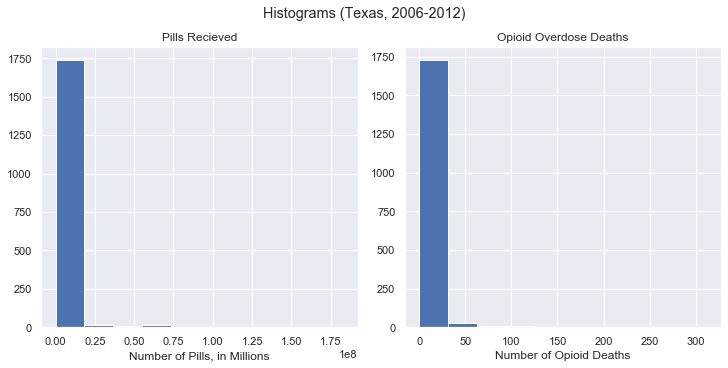

In [92]:
# Let's see the distribution of each variable, before preprocessing
fig1, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)

fig1_1 = merged_data["DOSAGE_UNIT"].hist(ax=axes[0])
fig1_2 = merged_data["NUM_DEATHS"].hist(ax=axes[1])

fig1_1.title.set_text("Pills Recieved")
fig1_2.title.set_text("Opioid Overdose Deaths")

fig1_1.set_xlabel("Number of Pills, in Millions")
fig1_2.set_xlabel("Number of Opioid Deaths")
fig1.suptitle("Histograms (Texas, 2006-2012)")

plt.show()

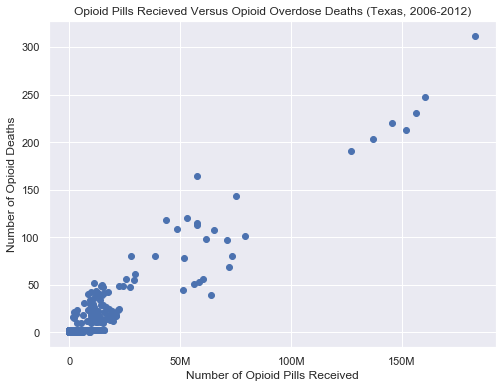

In [93]:
# Let's also investigate the relationship
plt.figure(figsize=(8, 6))

plt.scatter(x=merged_data["DOSAGE_UNIT"], y=merged_data["NUM_DEATHS"])

plt.xticks(np.arange(0, 200000000, step=50000000),
           labels=("0", "50M", "100M", "150M"))
plt.ylabel("Number of Opioid Deaths")
plt.xlabel("Number of Opioid Pills Received")
plt.title("Opioid Pills Recieved Versus Opioid Overdose Deaths (Texas, 2006-2012)")
plt.show()

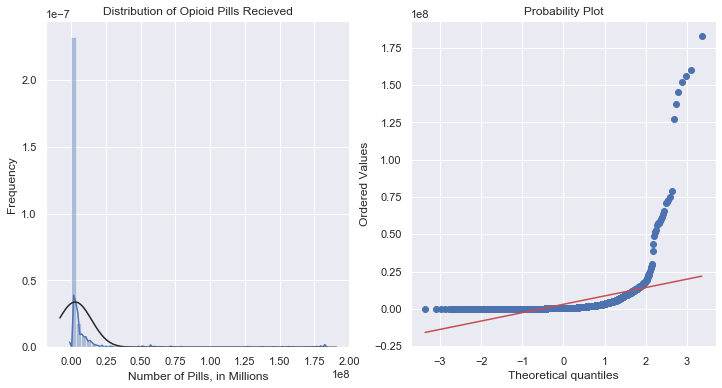

In [53]:
# Plotting another distribution plot, plus a Q-Q plot to check skew
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

# By setting fit=norm, we can better compare to a normal distribution
sns.distplot(merged_data["DOSAGE_UNIT"], fit=norm, ax=ax1)
stats.probplot(merged_data["DOSAGE_UNIT"], plot=ax2)

ax1.set_title("Distribution of Opioid Pills Recieved")
ax1.set(xlabel="Number of Pills, in Millions", ylabel="Frequency")

plt.show()
# As you can see, very skewed

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

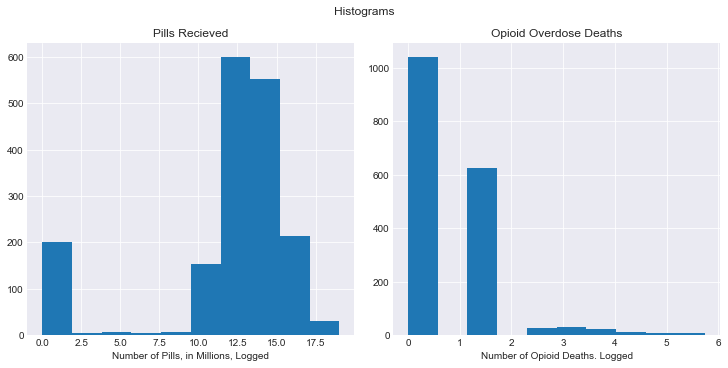

In [46]:
# Let's see the distribution of each variable, now that we've processed
fig2, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)

fig2_1 = merged_data["DOSAGE_UNIT_LOG"].hist(ax=axes[0])
fig2_2 = merged_data["NUM_DEATHS_LOG"].hist(ax=axes[1])

fig2_1.title.set_text("Pills Recieved")
fig2_2.title.set_text("Opioid Overdose Deaths")

fig2_1.set_xlabel("Number of Pills, in Millions, Logged")
fig2_2.set_xlabel("Number of Opioid Deaths. Logged")
fig2.suptitle("Histograms")

plt.show()

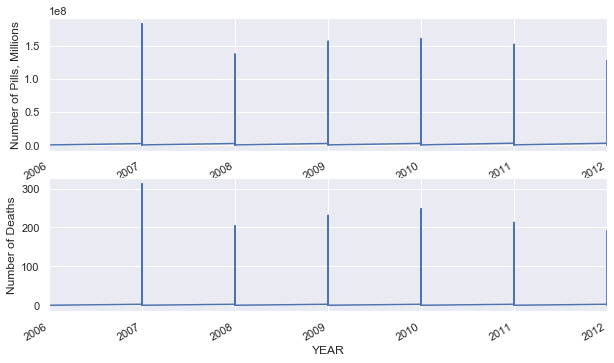

In [100]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
year_index["DOSAGE_UNIT"].plot()
plt.ylabel("Number of Pills, Millions")

plt.subplot(2,1,2)
year_index["NUM_DEATHS"].plot()
plt.ylabel("Number of Deaths")

plt.show()